# Determining Elastic Modulus using MD Analysis

## Importing Libraries

In [1]:
#importing required libraries
from classes.constantsmd import *
from classes.gridmd import *
from classes.functionsmd import *
from numpy import sin, cos, deg2rad, matrix, size, invert, multiply, array, sqrt, ones, empty, sum, average, abs, log, mean
from matplotlib.pyplot import plot, scatter, loglog
import datetime

#import matplotlib.pyplot as plt
#from sympy import init_printing
#from mpl_toolkits.mplot3d import Axes3D
#import csv
#import pandas as pd
print("-----------start-----------")

called constantmd
called gridmd
called functionsmd
-----------start-----------


## Writing Log

In [2]:
now = datetime.datetime.now()
file = open("dump/inputdata_"+str(now.strftime("%d-%m-%Y %H:%M"))+".txt", "w")
file.write("datetime : "+str(now.strftime("%d-%m-%Y %H:%M"))+"\n")
file.write("avagadro : "+str(avagadro)+"\n")
file.write("ial : "+str(ial)+"\n")
file.write("epsilon : "+str(epsilon)+"\n")
file.write("sigma : "+str(sigma)+"\n")
file.write("timestep : "+str(ts)+"\n")
file.write("N_steps : "+str(N_steps)+"\n")
file.write("N : "+str(N)+"\n")
file.write("Fa : "+str(Fa)+"\n")
file.write("mass : "+str(mass)+"\n")
file.write("FaByMass : "+str(FaByMass)+"\n")
file.close()

In [3]:
#N = N_xyz(10,6,6)
coor_0 = initialPosSC(N,ial)

xyz_grid = xyzGrid(coor_0[0], coor_0[1], coor_0[2])

In [4]:
time_grid = np.zeros([N_steps,N[0],N[1],N[2],3])
time_grid[0] = np.array([xyz_grid])

force_grid = np.zeros([N_steps, N[0], N[1], N[2],3])

In [5]:
#%%timeit

for j in array(range(N[1])):
    for k in array(range(N[2])):
        force_grid[0, 0, j, k, 0] = -Fa / (N[1] * N[2])
        force_grid[0, N[0]-1, j, k, 0] = Fa / (N[1] * N[2])

In [6]:
for t in range(0, N_steps-1):
    file = open("dump/pos/timestep_"+str(t+1)+".xyz", "w")
    file.write(str(N[0]*N[1]*N[2])+'\n')
    file.write('\n')
    for i in range(N[0]):
        for j in range(N[1]):
            for k in range(N[2]):
                fx=0; fy=0; fz=0;acc=0
                fx = forceXLJ3(i, j, k, xyz_grid)
                fy = forceYLJ3(i, j, k, xyz_grid)
                fz = forceZLJ3(i, j, k, xyz_grid)
                #fx, fy, fz += forceLJ3(i, j, k, xyz_grid)
                acc = (fx/mass) + (force_grid[t, i, j, k , 0]/mass)
                if (t-1==-1):
                    xj=verlet_pos(time_grid[t][i][j][k][0], time_grid[t][i][j][k][0], t,ts,acc)
                    yj=verlet_pos(time_grid[t][i][j][k][1], time_grid[t][i][j][k][1], t, ts, 
                                      fy/mass)
                    zj=verlet_pos(time_grid[t][i][j][k][2], time_grid[t][i][j][k][2], t, ts, 
                                      fz/mass)
                else:
                    xj=verlet_pos(time_grid[t][i][j][k][0], time_grid[t-1][i][j][k][0], t,ts,acc)
                    yj=verlet_pos(time_grid[t][i][j][k][1], time_grid[t-1][i][j][k][1], t, ts, 
                                  fy/mass)
                    zj=verlet_pos(time_grid[t][i][j][k][2], time_grid[t-1][i][j][k][2], t, ts, 
                                  fz/mass)
                time_grid[t+1][i][j][k][0] = xj
                time_grid[t+1][i][j][k][1] = yj
                time_grid[t+1][i][j][k][2] = zj
                file.write('X '+str(xj)+' '+str(yj)+' '+str(zj)+'\n')
                force_grid[t][i][j][k][0] = fx;force_grid[t][i][j][k][1] = fy;force_grid[t][i][j][k][2] = fz
    file.close()

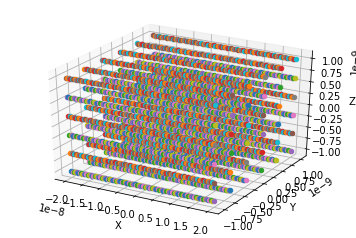

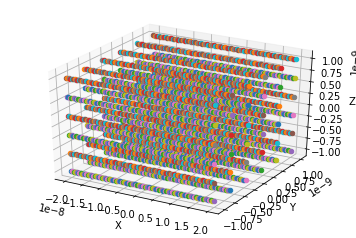

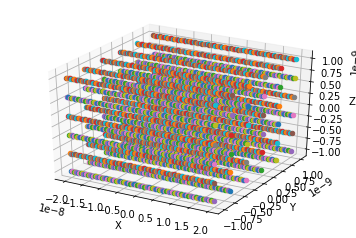

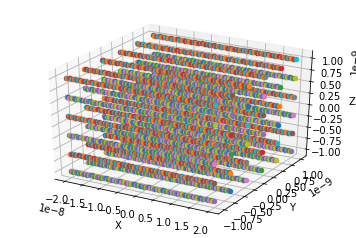

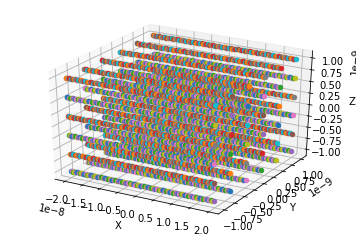

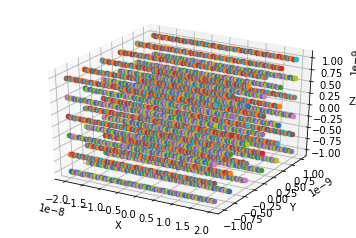

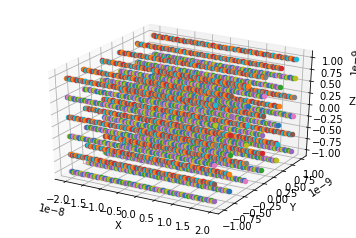

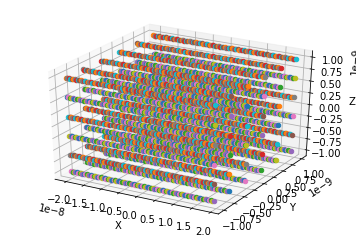

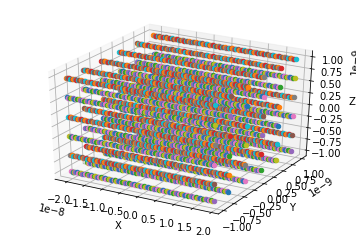

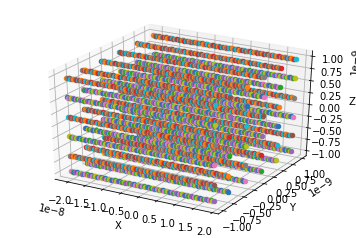

In [7]:
for time in range(N_steps):
    fig0 = plt.figure()
    ax = fig0.add_subplot(111, projection='3d')
    for i in time_grid[time,:,0,0,0]:
        for j in time_grid[time,0,:,0,1]:
            for k in time_grid[time,0,0,:,2]:
                ax.scatter(i,j,k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [8]:
def timeForceMeanAndTimeStress():
    time_forceMean = np.zeros([N_steps, 3])
    time_stress = np.zeros([N_steps, 3])
    time_stress_applied = np.zeros([N_steps, 3])
    fxMean = 0;fyMean = 0;fzMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    fxMean+=force_grid[t][i][j][k][0]
                    fyMean+=force_grid[t][i][j][k][1]
                    fzMean+=force_grid[t][i][j][k][2]
        fxMean = fxMean/N[0];fyMean = fyMean/N[1];fzMean = fzMean/N[2];
        time_stress[t] = np.array([fxMean/(N[1]*N[2]*ial**2), fyMean/(N[2]*N[0]*ial**2), fzMean/(N[1]*N[0]*ial**2)])#*68
        time_forceMean[t] = np.array([fxMean, fyMean, fzMean])
        time_stress_applied[t,0] = np.array([Fa/( abs(time_grid[t,0,0,0,1] - time_grid[t,0,N[1]-1,0,1]) * abs(time_grid[t,0,0,0,2] - time_grid[t,0,0,N[2]-1,2]))])
    return time_forceMean, time_stress, time_stress_applied

In [9]:
time_forceMean, time_stress, time_stress_applied = timeForceMeanAndTimeStress()

In [10]:
time_stress[:,0]

array([-3.34867548e+11, -3.38216223e+11, -3.38249710e+11, -3.38250045e+11,
       -3.38250048e+11, -3.38250048e+11, -3.38250048e+11, -3.38250048e+11,
       -3.38250048e+11, -3.38250048e+09])

In [11]:
strainXYZ = np.zeros([N[0], N[1], N[2], 3])
time_strainXYZ = np.zeros([N_steps, N[0], N[1], N[2], 3])
time_strainXYZ[0] = strainXYZ
for t in range(N_steps):
    if t==0:
        pass #strainX[t] = 0
    else:
        strainXYZ = abs(time_grid[t]-time_grid[0])/ial
        time_strainXYZ[t] = strainXYZ

In [12]:
#time_strainMean = np.zeros([N_steps, 3])

In [13]:
def timeStrainMean():
    time_strainMean = np.zeros([N_steps, 3])
    StrainXMean = 0;StrainYMean = 0;StrainZMean = 0;
    for t in range(N_steps):
        for i in range(N[0]):
            for j in range(N[1]):
                for k in range(N[2]):
                    StrainXMean+=time_strainXYZ[t][i][j][k][0]
                    StrainYMean+=time_strainXYZ[t][i][j][k][1]
                    StrainZMean+=time_strainXYZ[t][i][j][k][2]
        StrainXMean = StrainXMean/N[0];StrainYMean = StrainYMean/N[1];StrainZMean = StrainZMean/N[2];
        time_strainMean[t] = np.array([StrainXMean, StrainYMean, StrainZMean])
    return time_strainMean

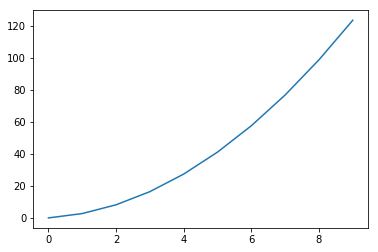

In [14]:
time_strainMean = timeStrainMean()
plot(range(N_steps) ,time_strainMean[:,0])

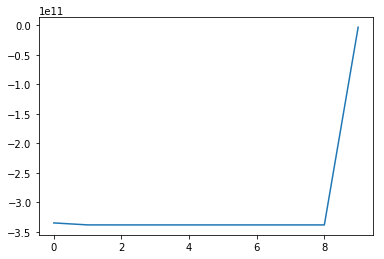

In [15]:
plot(range(N_steps) ,time_stress[:,0])

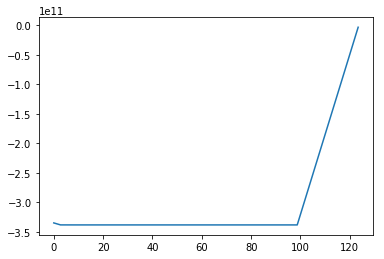

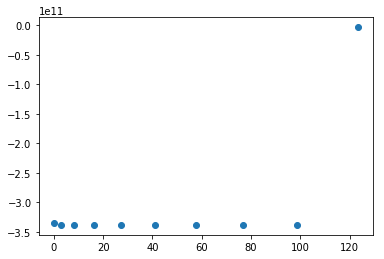

In [16]:
n=25
#fig, axs = plt.subplot(1,2)

plot(time_strainMean[:n,0], time_stress[:n,0])
plt.show()
scatter(time_strainMean[:n,0], time_stress[:n,0])#/1e-14)
plt.show()

In [17]:
for i in range(N_steps):
    print( (time_stress[i][0]/time_strainMean[i][0])/1e9,"GPa")

-inf GPa
-124.34259880301774 GPa
-41.31384165996366 GPa
-20.622321788900408 GPa
-12.360921354603725 GPa
-8.235071129512017 GPa
-5.879365940879607 GPa
-4.407934124914133 GPa
-3.4274313091167254 GPa
-0.027413295201041 GPa


/home/krish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


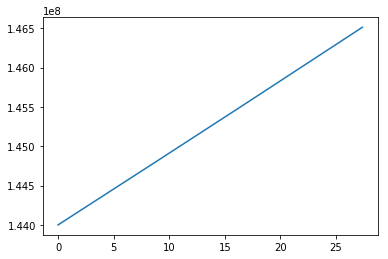

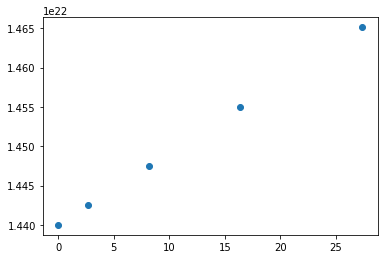

In [18]:
n=5
#fig, axs = plt.subplot(1,2)

plot(time_strainMean[:n,0], time_stress_applied[:n,0])
plt.show()
scatter(time_strainMean[:n,0], time_stress_applied[:n,0]/1e-14)
plt.show()

In [19]:
import platform
platform.system()
if(platform.system()=='Windows'):
    import winsound
    duration = 1000  # millisecond
    freq = 440  # Hz
    winsound.Beep(freq, duration)
if(platform.system()=='Linux'):
    import os
    os.system('spd-say "your program is finished"')


In [20]:
print("------------end------------")

------------end------------


In [21]:
time_strainMean

array([[  0.        ,   0.        ,   0.        ],
       [  2.72003502,   0.85231225,   0.85231225],
       [  8.18732164,   2.6989888 ,   2.6989888 ],
       [ 16.40213203,   5.56370498,   5.56370498],
       [ 27.3644689 ,   9.45040669,   9.45040669],
       [ 41.0743323 ,  14.35975158,  14.35975158],
       [ 57.53172221,  20.29184924,  20.29184924],
       [ 76.73663863,  27.24671796,  27.24671796],
       [ 98.68908158,  35.22436077,  35.22436077],
       [123.38905104,  44.22477818,  44.22477818]])